In [1]:
from BIDS.snapshot2D import create_snapshot,Snapshot_Frame,Visualization_Type,Image_Modes
from pathlib import Path
from IPython.display import Image
import numpy as np
from BIDS import Centroids
from scipy import interpolate
import os

#Set working directory to parent of current working directory
os.chdir(os.path.join(os.path.dirname(os.getcwd()), "src"))

from utils._prepare_data import *
from utils.environment_settings import env_settings

dataset = [os.path.join(env_settings.DATA, "dataset-verse19"),  os.path.join(env_settings.DATA, "dataset-verse20"), os.path.join(env_settings.DATA, "dataset-tri")]
data_types = ['rawdata',"derivatives"]
image_types = ["ct", "subreg", "cortex"]
master_list = env_settings.MASTER_LIST
processor = DataHandler(master_list=master_list ,dataset=dataset, data_types=data_types, image_types=image_types)


[!] Unknown format seg-ano in file sub-verse602_dir-iso_seg-ano.nii.gz
[!] Unknown format iso-ctd in file sub-verse616_dir-iso_iso-ctd.json
[!] "verse549" is not a valid key/value pair. Expected "KEY-VALUE" in verse549_CT-iso_seg-ano.nii.gz
[!] "template" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] "sacrum" is not a valid key/value pair. Expected "KEY-VALUE" in sub-verse519_template_sacrum_msk.nii.gz
[!] Unknown format subreg in file sub-verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano_subreg.nii.gz
[!] "verse559" is not a valid key/value pair. Expected "KEY-VALUE" in verse559_CT-sag_seg-ano.nii.gz
[!] Unknown format ce-pv in file sub-tri087_ce-pv.nii.gz
[!] Unknown format ce-ar in file sub-tri129_ce-ar.nii.gz
[!] Unknown format ce-late in file sub-tri023_ce-late.nii.gz
[!] Unknown format ce-ne in file sub-tri026_ce-ne.nii.gz
[!] Unknown format stat 

In [2]:
def calculate_angle_dist(ctd: Centroids):
    last_L = 25 if 25 in ctd.centroids.keys() else 24 if 24 in ctd.centroids.keys() else 23 if 23 in ctd.centroids.keys() else None
    assert(last_L is not None)
    prev_L = last_L - 1
    sac = 26

    assert(prev_L in ctd.centroids.keys())
    assert(sac in ctd.centroids.keys())

    v1 = np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[prev_L])
    v2 = np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[sac])

    #calculate angle between last_L and sac
    angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))

    #calculate distance between last_L and sac
    dist = np.linalg.norm(np.asarray(ctd.centroids[last_L]) - np.asarray(ctd.centroids[sac]))

    return angle, dist

In [9]:
angles = []
labels = []
records = []
distances = []

castellvi_encoding = {
    '0': 0,
    '1a': 10,
    '1b': 11,
    '2a': 20,
    '2b': 21,
    '3a': 30,
    '3b': 31,
    '4': 40,
}

for record in processor.verse_records + processor.tri_records:
    ctd = record["ctd_file"].open_cdt()
    ct = record["raw_file"].open_nii()
    ctd.zoom = ct.zoom
    if not ctd.shape:
        ctd.shape = ct.shape
    ctd = ctd.rescale((1,1,1), verbose=False)
    if not record["flip"]:
        try:
            angle, dist = calculate_angle_dist(ctd)
            angles.append(angle)
            distances.append(dist)
            labels.append(castellvi_encoding[record['castellvi']])
            records.append(record)
        except:
            print("Error in record: ", record['subject'])

Error in record:  verse116
Error in record:  verse034


In [10]:
# Print count of each label
print("Count of each label: ", np.unique(labels, return_counts=True))

Count of each label:  (array([ 0, 20, 21, 30, 31, 40]), array([322,  46,  29,  18,  32,   8]))


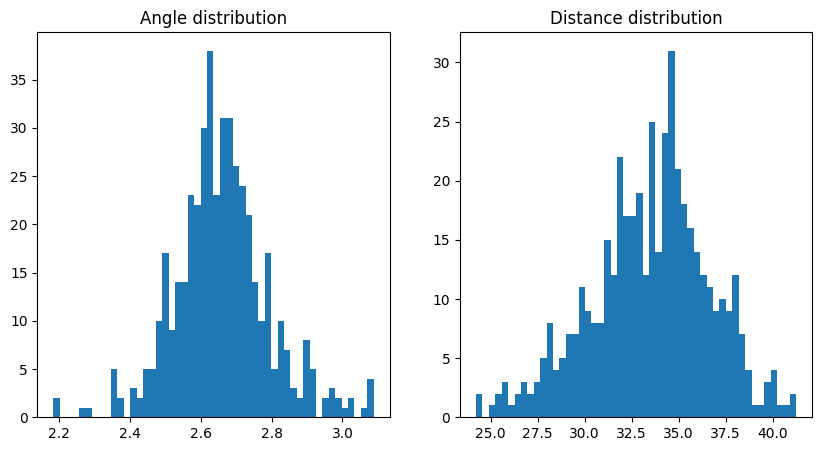

In [11]:
# Plot dsitribtion of angles and distances side by side
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(angles, bins=50)
axs[0].set_title("Angle distribution")
axs[1].hist(distances, bins=50)
axs[1].set_title("Distance distribution")
plt.show()

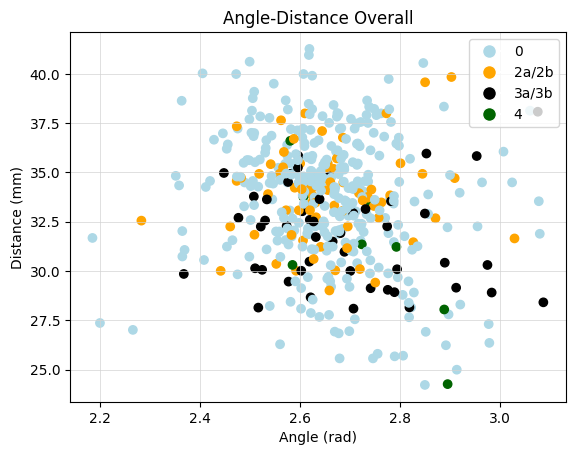

In [12]:
#Plot angle-distance as scatter plot colored by label with legend for color coding
scatter = plt.scatter(angles, distances, c=["lightblue" if label == 0 else "orange" if (label == 20 or label == 21) else "black" if (label == 30 or label == 31) else "darkgreen" for label in labels])
plt.xlabel("Angle (rad)")
plt.ylabel("Distance (mm)")
plt.title("Angle-Distance Overall")

#Add lightgrey grid
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)

#Make custom legend for color coding
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='lightblue', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='2a/2b', markerfacecolor='orange', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='3a/3b', markerfacecolor='black', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='4', markerfacecolor='darkgreen', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

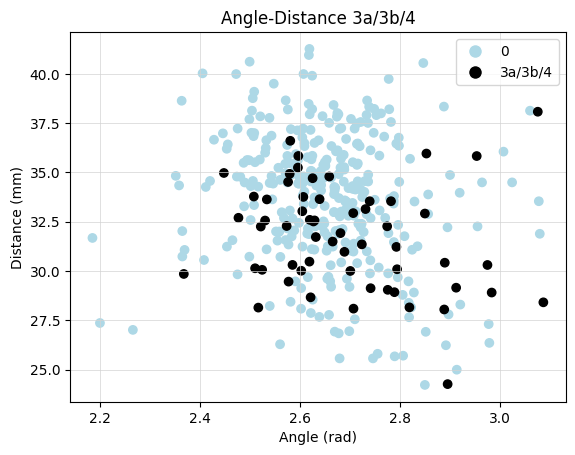

In [14]:
#Plot angle-distance as scatter plot colored by label with legend for color coding
labels = np.asarray(labels)
angles = np.asarray(angles)
distances = np.asarray(distances)

idx_0 = np.where(labels == 0)
idx_30 = np.where(labels == 30)
idx_31 = np.where(labels == 31)
idx_40 = np.where(labels == 40)

idx = np.concatenate((idx_0[0], idx_31[0], idx_40[0], idx_30[0]))

scatter = plt.scatter(angles[idx], distances[idx], c=["lightblue" if label == 0 else "black" for label in labels[idx]])
plt.xlabel("Angle (rad)")
plt.ylabel("Distance (mm)")
plt.grid(color='lightgrey', linestyle='-', linewidth=0.5)
plt.title("Angle-Distance 3a/3b/4")
#Make custom legend for color coding
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='lightblue', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='3a/3b/4', markerfacecolor='black', markersize=10)]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()

In [15]:
#fit two-dimensional logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score

X = np.asarray(list(zip(angles, distances)))
y = np.asarray(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Confusion matrix: ", confusion_matrix(y_test, y_pred))

Accuracy:  0.7692307692307693
Confusion matrix:  [[70  0  0  0  0  0]
 [ 5  0  0  0  0  0]
 [ 5  0  0  0  0  0]
 [ 3  0  0  0  0  0]
 [ 6  0  0  0  0  0]
 [ 2  0  0  0  0  0]]


####################################
/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/daniel/anaconda3/envs/dev-castellvi/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/daniel/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File 

Not a single instance of the minority class can be separated by a linear decision boundary, which is why the logistic regression does not converge and the classifier only predicts the majority class.

In [16]:
#get a record with label 0 and 31
idx = np.where(np.asarray(labels) == 0)[0][2]
record_0 = records[idx]
angle_0 = angles[idx]
dist_0 = distances[idx]
idx = np.where(np.asarray(labels) == 31)[0][3]
record_31 = records[idx]
angle_31 = angles[idx]
dist_31 = distances[idx]

ct_0, seg_0, ctd_0 = processor.get_ct_seg_ctd_cutout(record_0)
ct_31, seg_31, ctd_31 = processor.get_ct_seg_ctd_cutout(record_31)

spline_0, spline_0_der = fit_spline(ctd_0, max_dim = 128)
spline_31, spline_31_der = fit_spline(ctd_31, max_dim = 128)


# Plot spline_0 and spline_31
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(spline_0[:,2], spline_0[:,0], -spline_0[:,1], c='r', marker='o')
ax.scatter3D(spline_31[:,2], spline_31[:,0], -spline_31[:,1], c='b', marker='o')
ax.axis('equal')
plt.show()


NameError: name 'fit_spline' is not defined